# Application of QuEStVar on the Spiked-in Data

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The data used here comes from the previous notebook where I prepared the data for the `questvar` testing framework. The data is stored in the `data/processed/` folder and is described in the previous notebook. Especially the `data/processed/samples/` folder that contains the subset of each sample saved as a feather file will be called when each pair comparison is run. 

**Notebook Summary:**

This notebook uses the prepared data from the previous notebook to run the `questvar` testing framework and summarize the results for selected comparisons. In the end, I also compare the correlation coefficient and sample equivalence index (extracted with `questvar`) to see a more robust way to measure sample similarity.

## Setup Notebook

This part is a standard for my notebooks, where I import all the used libraries, set the notebook's design, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os 
import sys
import feather # fast, efficient file for i/o
from itertools import product, combinations 

import numpy as np # Python's numerical library
import pandas as pd # Python's data manipulation library

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from questvar import test, utils, plots
# import warnings; warnings.filterwarnings('ignore')
startTime = utils.getTime()

### Notebook's Design

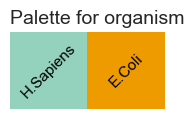

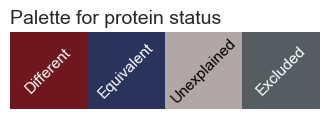

In [2]:
### Notebook Configuration

# Set random seed
np.random.seed(42)

# Colors
organism_colors = {
    "H.Sapiens": "#94d2bd",
    "E.Coli": "#ee9b00",
}
# Color dict for the protein status
status_colors = {
    "Different": "#70161e",
    "Equivalent": "#29335c",
    "Unexplained": "#b1a7a6",
    "Excluded": "#565d61"
}

## Configure some general styling

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    # palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"] # formats to save figures in
save_to_folder = True           # enable saving figures to folder
transparet_bg = True            # enable transparent background
figure_dpi = 300                # figure resolution

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

## Color Palettes used

plots.color_palette(
    organism_colors,
    name = "organism"
)
# Protein status colors
plots.color_palette(
    status_colors,
    name = "protein status"
)

### Data and Result Paths

The data and figure paths are defined here. The data path is the same as the previous notebook, and the figure path is set to the `figures/` folder. However, to store the results of the `questvar` testing framework, I create a new folder called `results/`, which will store the `stat_data` and `info_data` subfolders, containing the output of the `questvar` per sample pair comparison. The data is saved as feather files for efficient storage and fast write/read.

The `data/processed/` and `data/processed/samples/` folders are created in the previous notebook and must be present for this notebook to run. The `results/` folder is created here.

In [3]:
# Establish the paths
notebook_name = "application"                   # Notebook name

data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Main figure folder
input_path = f"{data_path}processed/"           # Main input folder
quant_path = f"{input_path}samples/"            # Folder with subsetted sample feather files
output_path = f"{data_path}results/"            # Main output folder
stat_path = f"{output_path}stat_data/"          # Subfolder to store stat result feather files
info_path = f"{output_path}info_data/"          # Subfolder to store info result feather files
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)

# Check if the paths exist
if not os.path.exists(quant_path):
    raise ValueError(
        f"Quant folder not found, run the notebook '01-Prepare_Input_Data.ipynb' first"
    )

# Create folders for various outputs
for i in [output_path, stat_path, info_path, supp_path]:
    if not os.path.exists(i):
        os.makedirs(i)    

# Create folders for figure formats
for i in figure_formats:
    cur_folder = fig_path + i + "/"
    if not os.path.exists(cur_folder):
        os.makedirs(cur_folder)       

## Setup the Data

Opening and setting up the data that will be used in the notebook, produced in the previous notebook.

### Read the  Metadata

The simple metadata is read from the `data/processed/metadata.feather` file, containing column names and the sample group information.

In [4]:
metadata = feather.read_dataframe(
    input_path+"metadata.feather"
).sort_values(
    by=["Sample", "columnName"]
).reset_index(drop=True)


print("Data Shape:", metadata.shape)
metadata.head()

Data Shape: (92, 2)


,columnName,Sample
0,Lymph_Ecoli_1-6_011,1-06
1,Lymph_Ecoli_1-6_012,1-06
2,Lymph_Ecoli_1-6_013,1-06
3,Lymph_Ecoli_1-6_026,1-06
4,Lymph_Ecoli_1-6_027,1-06


### Protein Information Data

The protein information data is read from the `data/processed/protein_info_data.feather`, which is the subsetted fasta file containing the protein information for the proteins present in the data. It allows the merging of this information for reporting and informative plotting purposes.

In [5]:
protein_info_data = feather.read_dataframe(input_path+"protein_info_data.feather")
protein_info_data.head()

,entry,entryName,geneName,sequenceLength,organism
0,A0A075B6H9,LV469_HUMAN,IGLV4-69,119,H.Sapiens
1,A0A075B6I9,LV746_HUMAN,IGLV7-46,117,H.Sapiens
2,A0A075B6K4,LV310_HUMAN,IGLV3-10,115,H.Sapiens
3,A0A075B6R9,KVD24_HUMAN,IGKV2D-24,120,H.Sapiens
4,A0A0A0MS15,HV349_HUMAN,IGHV3-49,119,H.Sapiens


### Averaged Replicates Data

The averaged replicates data is read from the `data/processed/averaged_quantdata.feather` file, which is the subsetted data that contains the averaged replicates for each sample. This data is used for overall sample standing and protein-rank plot. 

Using the averaged replicate data, I create the protein_data table containing mean intensity in log2 scale for each protein, the rank based on the mean intensity in descending order, and the overall CV calculated between averaged replicate samples. This data is used for the protein-rank plot.

In [6]:
## Open Average Data
sample_average = feather.read_dataframe(
    input_path+"averaged_quantdata.feather"
)
sample_average_log2 = np.log2(sample_average)
allProteins = sample_average.index.tolist()
protein_data = pd.DataFrame({
    "Mean": sample_average_log2.mean(axis=1),
    "Rank": sample_average.mean(axis=1).rank(ascending=False),
    "CV": sample_average.std(axis=1) / sample_average.mean(axis=1) * 100,
})
print(protein_data.shape)
protein_data.head()

(5389, 3)


,Mean,Rank,CV
Q86U42,19.0721,1437.0000,2.7478
P37108,19.6226,766.0000,4.8715
Q96JP5,18.3798,2773.0000,7.9871
Q8N697,18.8846,1753.0000,8.6311
O75822,18.9356,1658.0000,4.0893


# Run QuEStVar Framework

## Setup and Run Testing Framework

### Variables for Setup

The variables used for the setup of the testing framework are defined here. It takes multiple variables to set up the framework, which is explained below.

- **pThr**: This variable takes a float value indicating the p-value threshold. The default value is .05
- **dfThr**: This variable takes a float value indicating the log2 fold-change boundary used to determine the statistically different proteins as an additional filter to the p-value. The default value is 1, which means that the proteins with log2 fold-change greater than 1 or less than -1 are considered statistically different if their adjusted p-value is less than the `pThr`.
- **eqThr**: This variable takes a float value indicating the equivalence threshold. The default value is .5, which means that the proteins with log2 fold-change less than .5 or greater than -.5 are considered equivalent if their adjusted p-value is less than the `pThr`.
- **cvThr**: This variable takes a float value indicating the coefficient of variation (CV) threshold. The CV is used to filter out unreliably quantified proteins. Each protein's CV must be less than the cover to be considered reliable for both samples. The default value is 75. However, this must be adjusted based on the data and user preference. Another thing to note is that CV values calculated from non-scale to log-scale vary, and the user should be aware of this.
- **is_log2**: This variable takes a boolean value, indicating whether the data is in the log2 scale. No default value is set, and the user must set this variable to True if the data is in the log2 scale. Internally, the testing is based on the log2 scale. The CV values are calculated from the non-log2 scale data and then converted to the log2 scale.
- **var_equal**: This variable takes a boolean value, indicating whether the variance is equal. No default value is set, and the user must set this variable to True if the variance is equal. This determines the type of t-test used for the testing. If the variance is equal, then the standard t-test is used, otherwise the Welch's t-test is used.
- **correction_method**: This variable takes a string value indicating the method used for multiple testing correction. The default is `fdr`, which is the Benjamini-Hochberg method. The other options are `bonferroni`, `holm`, and `qvalue`. The user can also set this variable to `None` to skip multiple testing corrections, which is not recommended.
- **is_paired**: This variable takes a boolean value indicating whether the samples are paired. No default value is set, and the user must set this variable to True if the samples are paired. This determines the type of t-test used for the testing. If the samples are paired, the paired t-test is used; otherwise, the unpaired t-test is used.
- **combs_list**: A list of tuples containing the sample names to be tested pairwise. This can be a subset of the samples or all of the samples. 

For the testing here, even though I will be using four comparisons, I will run all 6 possible combinations of the samples for testing using the `combinations` function from the `itertools` library. The `combs_list` variable is defined here.

One thing to note is that in addition to 6 possible combinations, I add the pair `("Lymphnode", "Lymphnode")`, which tests the exact same samples against each other. This is done to see how the framework handles the same samples and is used at the end for the correlation coefficient and sample equivalence index comparison.

In [7]:
# Parameters used for the framework
pThr = 0.05
dfThr = 0.75
eqThr = 0.50
cvThr = 75 # 75% CV 
is_log2 = False
var_equal = True
is_paired = False
correction_method = "fdr"
combs_list = list(combinations(metadata["Sample"].unique(), 2)) + [("Lymphnode", "Lymphnode")]
if correction_method is None:
    print("WARNING! 'None' is selected, No correction method will be applied.")

# Print the parameter setup
test.printParams(
    combs_list, 
    pThr,
    dfThr,
    eqThr,
    cvThr,
    is_log2,
    var_equal,
    correction_method,
    is_paired
)

Test Parameters:
  - p-value threshold: 0.05
  - Equal variance: True
  - Use Paired test: False
  - Data in log2 Scale: False
  - Correction method: fdr
  - Filter higher than CV%: 75
  - Difference lfc boundary: (-0.75, 0.75)
  - Equivalence lfc boundary: (-0.5, 0.5)

Multiple tests for:
  - 1) 1-06 vs 1-12
  - 2) 1-06 vs 1-25
  - 3) 1-06 vs Lymphnode
  - 4) 1-12 vs 1-25
  - 5) 1-12 vs Lymphnode
  - 6) 1-25 vs Lymphnode
  - 7) Lymphnode vs Lymphnode


### Running the Combinations

This runs the `test.by_pair` function on all the combinations using the parameters set earlier. For this dataset, I loop over each combination and run them individually. However, this can be parallelized for larger datasets to speed up the process, which I will point out in the following dataset's analysis notebook.

Simple operational logic of this function is as follows:
1. Takes the two samples from the combination list
2. Read each sample from the `data/processed/samples/` folder
3. Checks if the index of the samples is the same -> error if not
4. Saves the index as reference (can be proteins or numeric index)
5. Filters out the proteins based on missing values and CV threshold
6. Subsets both based on remaining in both
7. If data is not in the log2 scale, then convert it to the log2 scale
8. Based on the `is_paired` variable runs the paired or unpaired t-test (`run_unpaired` or `run_paired` functions within the `test` script)
    1. runs test for difference with two-sided alternative hypothesis 
    2. Adjust the p-values from the difference test with the `correction_method` variable
    3. runs test for equivalence with two one-sided alternative hypotheses (less and greater)
    4. Adjust the p-values from the equivalence test with the `correction_method` variable
    5. Finds the highest from greater and lesser p-values and uses that as the adjusted p-value for the equivalence test, which represents the equivalence p-value
    6. Calculate if the protein is statistically different or equivalent based on the p-value and log2 fold-change (LFC) thresholds
    7. Calculate the LFC from the mean of the two samples
    8. Using the `eqThr` protein, significance is selected if LFC is within the `eqThr` and the equivalence p-value is less than the `pThr`. It is considered equivalent
    9. Using the `dfThr` protein, significance is selected if LFC is greater than the `dfThr` or less than the `-dfThr` and the difference p-value is less than the `pThr`, it is considered different
    10. All the statistical data is returned in a NumPy array
9. The statistical data is converted to a Pandas data frame and saved as a feather file in the `results/stat_data/` folder (only contains the tested proteins)
10. The information data is created using all proteins, their status (missing, filtered, kept) per sample and the protein status (different, equivalent, excluded, unexplained) and saved as a feather file in the `results/info_data/` folder.
    
Depending on the number of samples and the number of proteins, this can take a long time to run, and if the storage saving system is not used, it will create large memory usage. However, the feather files are very efficient in terms of storage, and the `test.by_pair` function is also designed to be memory efficient. When paired with parallelization, this can run on very large datasets and reasonably. 

In [8]:
start_time = utils.getTime()
print("Sample Pairs to test:")
# Loop through all the pairs and run the test
for cur_comb in combs_list:
    print(cur_comb)
    test.by_pair(
        cur_comb, 
        quant_path, 
        stat_path, 
        info_path,
        is_log2,
        cvThr, 
        pThr, 
        dfThr, 
        eqThr, 
        var_equal,
        is_paired,
        correction_method
    )
print(f"Time taken for {len(combs_list)} pairs:", utils.prettyTimer(utils.getTime()- start_time))

Sample Pairs to test:
('1-06', '1-12')
('1-06', '1-25')
('1-06', 'Lymphnode')
('1-12', '1-25')
('1-12', 'Lymphnode')
('1-25', 'Lymphnode')
('Lymphnode', 'Lymphnode')
Time taken for 7 pairs: 00h:00m:00s


### Exclusion of Proteins

The exclusion of proteins is done based on the missing values and CV threshold per sample during testing. 

The percentage of excluded proteins is calculated by dividing the number of excluded proteins by the total number of proteins. The excluded proteins are the proteins that are filtered out during testing due to missing values or CV threshold. The excluded proteins are not tested for difference or equivalence and are not included in the statistical data.

To quickly check the percentage of proteins excluded per sample, I made a boxplot of each sample's percentage of excluded proteins. This is done by reading the `results/info_data/` folder, extracting the information data for each sample and calculating the percentage of excluded proteins. 

Percentage of Excluded Proteins
 ('1-06', '1-12') -> 7.163
 ('1-06', '1-25') -> 12.136
 ('1-06', 'Lymphnode') -> 20.078
 ('1-12', '1-25') -> 13.231
 ('1-12', 'Lymphnode') -> 21.618
 ('1-25', 'Lymphnode') -> 19.911
 ('Lymphnode', 'Lymphnode') -> 17.406


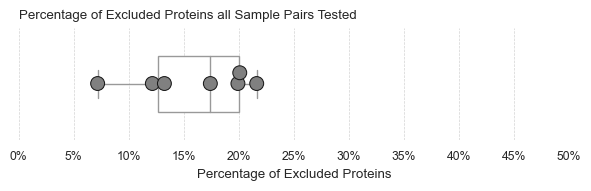

In [9]:
exclusion_percentages = []
for cur_comb in combs_list:
    cur_file = "_vs_".join(cur_comb)
    info_res = feather.read_dataframe(info_path+cur_file+".feather")
    info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
        -1.0: "Different",
        1.0 : "Equivalent",
        0.0 : "Unexplained",
        -2  : "Excluded"
    })
    info_res["Status"].value_counts()
    exclusion_percentages.append(
        info_res["Status"].value_counts(normalize=True)["Excluded"] * 100
    )
exclusion_percentages = pd.Series(exclusion_percentages, index=combs_list)

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 2))
# Plot boxplot
sns.boxplot(
    x=exclusion_percentages,
    ax=ax,
    color="white",
    width=.5,
    linewidth=1,
    fliersize=0,
)
# Plot swarmplot
sns.swarmplot(
    x=exclusion_percentages,
    ax=ax,
    color="gray",
    edgecolor="k",
    linewidth=.75,
    size=10
)

# Set the labels
ax.set_xlabel("Percentage of Excluded Proteins")
ax.set_ylabel("")
ax.set_title(
    "Percentage of Excluded Proteins all Sample Pairs Tested", 
    loc="left"
)
# Set the ticks
ax.set_xticks(np.arange(0, 51, 5))
# Set them as percentages
ax.set_xticklabels([str(i)+"%" for i in np.arange(0, 51, 5)])
ax.set_yticks([])
# Set the limits

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "TestedPairs_ExclusionPercentages_BoxPlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

utils.print_series(
    exclusion_percentages.round(3),
    header="Percentage of Excluded Proteins",
)

There are two clusters of pairs, pairs with Lymphnode and pairs without Lymphnode. The pairs with Lymphnode have a higher percentage of excluded proteins, which is expected since the Lymphnode samples have no E.coli proteins (very few); when tested against the E.coli samples, they will be excluded by default.

Our reference comparison is the `("Lymphnode", "Lymphnode")` pair, which is the exact same samples. This shows that 17% of the proteins are excluded. Let's check the reason behind the exclusion.

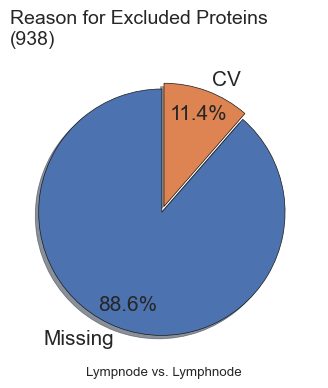

In [10]:
plot_data = info_res.copy()
plot_data["S1_Status"] = plot_data["S1_Status"].map({
    -1: "CV",
    0: "Missing",
    1: "OK"
})
plot_data = plot_data["S1_Status"].value_counts().iloc[1:]
ax = plot_data.plot.pie(
    autopct="%.1f%%",
    # colors=["#70161e", "#b1a7a6"],
    startangle=90,
    wedgeprops={"linewidth": 0.5, "edgecolor": "k"},
    explode=[0.05, 0],
    shadow=True,
    textprops={"fontsize": 15},
    pctdistance=0.8,
    figsize=(5, 4),
    # labels=None,
)

ax.set_ylabel("")
ax.set_xlabel("Lympnode vs. Lymphnode")
ax.set_title(
    f"Reason for Excluded Proteins\n({plot_data.sum()})",
    loc="left", 
    fontsize=14
)

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ExcludedProteins_Reasons_PieChart",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Of the 938 excluded proteins, ~89% are excluded due to missing values (E.coli Proteins), and ~11% are excluded due to CV threshold.

# Case Study 

In this section, I will look at individual comparisons and their results in detail. I will be looking at three comparisons in detail, (1:06 vs 1:25), (1:06 vs 1:12), and (1:06 vs Lymphnode). These comparisons are selected to highlight the E.coli differences at different magnitudes or no difference at all. 

## Pair with the Highest Expected Fold-Change: 1:06 vs 1:25

Based on how the e.coli ratio against the human lymphnode protein, we expect the highest fold-change to be between 1:06 and 1:25. This pair is selected to be the highest expected fold-change pair with 2.1 fold-change in e.coli and 0 fold-change in human proteins.

In [11]:
elfc_ecoli = 2.1 # Expected log2FC for E.coli
elfc_human = 0.0 # Expected log2FC for Human
s1 = "1-06"
s2 = "1-25"
cur_comb = (s1, s2)
cur_file = "_vs_".join(cur_comb)

# Get the info and stat data of the results for plotting
info_res = feather.read_dataframe(info_path+cur_file+".feather")
info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
    -1.0: "Different",
    1.0 : "Equivalent",
    0.0 : "Unexplained",
    -2  : "Excluded"
})

stat_res = feather.read_dataframe(stat_path+cur_file+".feather")
# Rename the columns
stat_res["Status"] = stat_res["Status"].replace({
    -1.0: "Different",
    1.0: "Equivalent",
    0.: "Unexplained"
})

# Save the testing results to a csv file for Supplementary Data 1
protein_info_data.set_index("entry").join(
    info_res.set_index("Protein")
).join(
    stat_res.iloc[:, :-3]
).to_csv(
    f"{supp_path}table_s1_3.csv"
)

### In-depth Summary of the Pair's Test Results

I designed two figure panels that can be used to check the single pair's test results in detail.

#### In-depth Protein Status Summary

This figure panel consists of 4 subplots. 
1. **(Top-Left)** Shows the protein status percentages as a result of the testing of a given pair. When calculating the percentages, the Equivalence and Difference percent can be represented using all proteins, only tested proteins, or only significant proteins as the total.
2. **(Top-Right)** Shows the protein status percentages within a binned rank range. The rank of proteins is calculated based on the protein's descending order of mean intensity across a given sample pair.
3. **(Bottom-Left)** Shows the protein exclusion matrix, indicating why the number of proteins is not used in the test and is considered excluded. X and Y axes are the samples, and the matrix indicates the retained, missing, and filtered. The number of proteins retained in both is the total number of proteins tested, highlighted with a yellow band around the rectangle.
4. **(Bottom-Right)** Shows the protein-rank plots with the hue indicating the protein status.

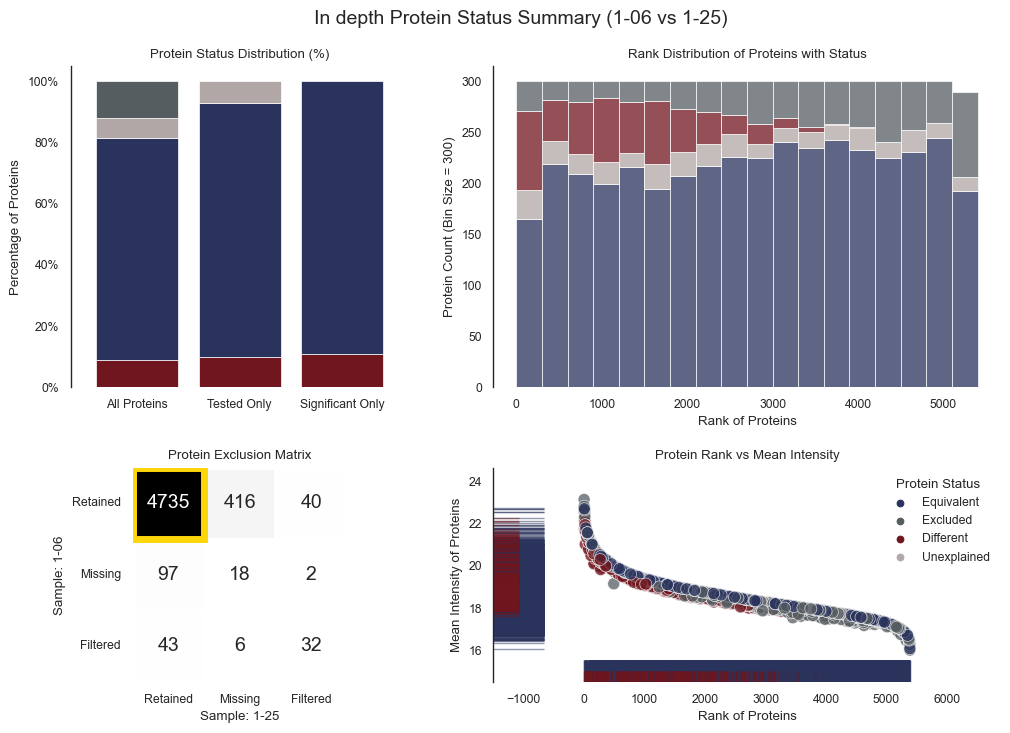

In [12]:
# Indepth summary visualization of single pairs test results
plots.single_pair_proteins_indepth(
    data = info_res,
    protein_data = protein_data,
    pair_names = cur_comb,
    # Data related parameters
    protein_col = "Protein",
    status_col = "Status",
    rank_col = "Rank",
    mean_col = "Mean",
    # Stats related parameters
    bin_size = 300,
    # Plot related parameters
    figsize = (12, 8),
    xMargin=1500,
    yMargin=1.5,
    save=save_to_folder,
    filepath=fig_path,
    filename = "single_pair_proteins_Indepth",
    fileformat=figure_formats,
    dont_show=False
)

For this dataset, most of the different proteins are from overall higher intensities, while equivalent proteins are uniformly distributed across the ranks. I can also see that most proteins are statistically equivalent, which is expected since there are primarily human proteins with no change. The protein exclusion matrix highlights the number of proteins removed because of Cv filtering and missing values from each sample. Missing in Sample 1:25 and Retained in Sample 1:06 are the E.coli proteins that are likely most of the E.coli proteins quantified in the more spike-in samples and not in the less spike-in samples.

#### Single Pair Testing Summary 

This figure panel consists of 4 subplots to highlight the statistical testing results of the pair.

1. The first column with 2 subplots is the p-value distribution of testing for difference and equivalence using step histogram. It also indicates the adjusted p-value with the darker colour in the same step-histogram overlayed. The x-axis for them is the p-value from 0 to 1, and the y-axis is the frequency with the bin created for the step-histogram.
2. The second column is the customized volcano plot called an "Antlers Plot" that shows the log2 fold-change on the x-axis and the adjusted p-value on the y-axis. The y-axis represents the p-value in the -log10 scale. The p-value used here is based on whether the protein's fold-change is within the equivalence threshold or not. If it is, the p-value from the equivalence test is used to plot; if it is not, the p-value from the difference test is used to plot. An upper side from 0 is -log10(Adj.p-value of Df), and the lower side from 0 is -log10(Adj.p-value of Eq). They both go from 0 to +Top. The Top is the maximum of the two p-values. The colour of the points is based on the protein status, different, equivalent, excluded, or unexplained. The dashed lines were also added at the x-axis for equivalence and difference thresholds and at the y-axis for p-value thresholds. The dashed lines are coloured based on the protein status as well.
3. The last column is the count-based bar plot of the protein status. This includes the excluded protein counts for reference, even though they are not used in the testing. The y-axis is the protein status, and the x-axis is the count of proteins. The colour of the bars is based on the protein status.

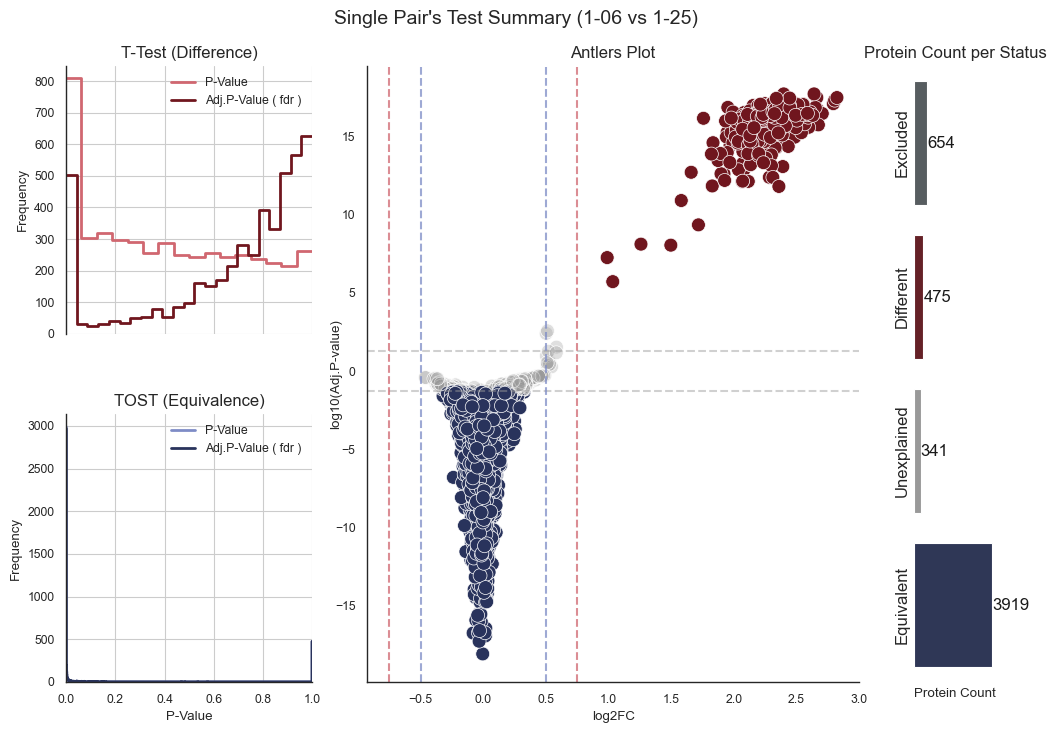

In [13]:
# Broader summary about the tested pair
plots.single_pair_summary(
    stat_res,
    info_res.shape[0],
    cur_comb,
    pThr=pThr,
    dfThr=dfThr,
    eqThr=eqThr,
    corr_name=correction_method,
    figsize=(12, 8),
    save=save_to_folder,
    filepath=fig_path,
    fileformat=figure_formats,
    dont_show=False
)

The equivalence p-value distributions are not legible because of the high number of equivalent proteins; most proteins are in smaller p-values. The small peaks at the end are the proteins with large fold changes that will result in close to 1 p-value in two one-sided t-tests. The difference p-value distributions are legible and what would be expected to see in general use, and they represent the raw to adjusted p-value distribution difference. The antlers plot also differs from what is generally expected to see because of how the samples are set. All the differences are in a single direction up-regulated in 1-06. However, it still can show the different, equivalent, and unexplained proteins regarding the boundaries.

#### Protein Status Overlayed on Intensity Comparison

In the previous notebook, I presented the scatterplot to compare samples using the single sample intensity over the fold-change of both samples. Here, I will be doing the same, but instead of organism-based colouring, I will use the protein status extracted from the statistical results of the pair.

This type of additional summary visualization applies to this data and can be used to compare the samples differently. However, this does not apply to all datasets, and the user should be aware of the data and the type of comparison they are doing.

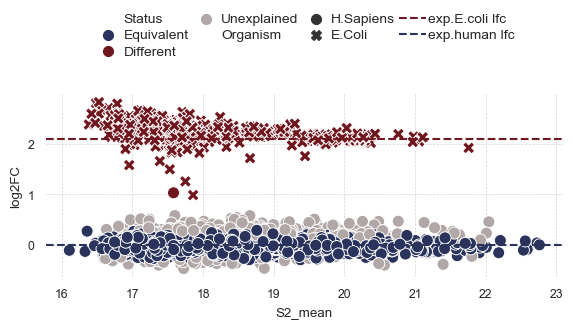

In [14]:
plot_data = stat_res[["Status", "log2FC"]].copy()

plot_data["Organism"] = plot_data.index.map(protein_info_data.set_index("entry")["organism"].to_dict())
cur_prots = plot_data.index
S1_mean = feather.read_dataframe(quant_path + f"{s1}.feather").loc[cur_prots, :].mean(axis=1)
S2_mean = feather.read_dataframe(quant_path + f"{s2}.feather").loc[cur_prots, :].mean(axis=1)
plot_data["S1_mean"] = np.log2(S1_mean)
plot_data["S2_mean"] = np.log2(S2_mean)
plot_data["mean"] = plot_data[["S1_mean", "S2_mean"]].mean(axis=1)

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
# Scatter plot with hue as the Status and shape as the organism
sns.scatterplot(
    data=plot_data,
    x="S2_mean",
    y="log2FC",
    hue="Status",
    style="Organism",
    palette=status_colors,
    ax=ax,
    s=75,
)

# Add the theoretical log2 fold change lines 
# for E. coli and human for selected Sample Pair
ax.axhline(
    y=elfc_ecoli, 
    color="#70161e", 
    linestyle="--", 
    linewidth=1.5,
    label="exp.E.coli lfc"
)
ax.axhline(
    y=elfc_human, 
    color="#29335c", 
    linestyle="--", 
    linewidth=1.5, 
    label="exp.human lfc"
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

ax.legend(
    frameon=False,
    ncol=4, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,

)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_Overlayed_Scatter_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

One of the human proteins is identified as different since it had high fold-change likely driven by E.coli peptide matching to the human protein. We can also see some E.coli proteins are very close to 1 fold-change, and because we used 0.75 as the boundary for difference, they still get picked up as different.

#### Protein Status per Organism 

This information is essential for this dataset since we know the E.coli proteins in a perfect world should differ from our boundaries, and the human proteins should be equivalent. This plot shows the protein status per organism, which is the number of different, equivalent, excluded, and unexplained proteins.

Protein status is the y-axis, and the number of proteins per status is the x-axis. The organism is used as a hue and stack bar configuration. 

Organism     H.Sapiens  E.Coli
Status                        
Equivalent        3918       1
Different            1     474
Unexplained        341       0
Excluded           341     313


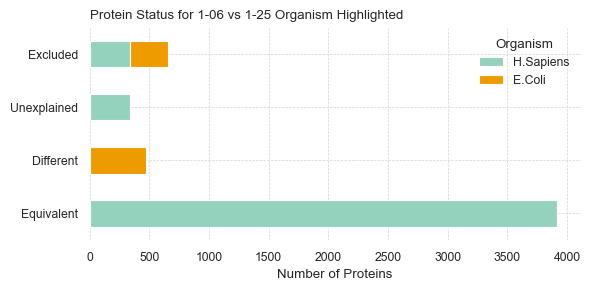

In [15]:
plot_data = info_res[["Protein", "Status"]].copy()

plot_data["Organism"] = plot_data["Protein"].map(
    protein_info_data.set_index("entry")["organism"].to_dict()
)
# plot_data.value_counts(["Organism", "Status"])
plot_data = plot_data.groupby([
    "Organism", "Status"
]).size().unstack().fillna(0).astype(int).T.loc[
    ["Equivalent", "Different", "Unexplained", "Excluded"],
    ["H.Sapiens", "E.Coli"]
]

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 3))

plot_data.plot.barh(
    ax=ax,
    stacked=True,
    color=organism_colors,
)

ax.set_xlabel("Number of Proteins")
ax.set_ylabel("")
ax.set_title(
    f"Protein Status for {s1} vs {s2} Organism Highlighted",
    # fontsize=10,
    # fontweight="bold",
    loc="left"
)
ax.legend(
    title="Organism",
    loc="upper right",
    frameon=False
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_StackedBar_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print(plot_data)

Most Different proteins are E.coli proteins, and most Equivalent proteins are human proteins, with single exceptions in both. 

---

As an alternative, I've built another plot to be used in the single-pair testing summary panel in the manuscript since Organism information is important for this data. 

Using a pie chart, this plot combines the protein status per organism and the protein status count plot. 

The inner circle with the colour of protein status has the number of proteins belonging to the protein status, and the outer donut chart shows the composition of that number with respect to the organism. 

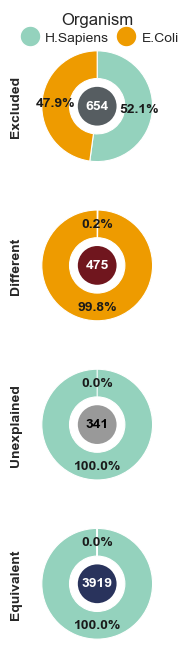

In [16]:
# Create 4 Pie charts for the 4 protein status
# Convert to percentages row-wise
plot_data = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

status_order = ["Excluded", "Different", "Unexplained", "Equivalent"]
custom_status_colors = {
        "Different": "#70161e",
        "Equivalent": "#29335c",
        "Unexplained": "#999999",
        "Excluded": "#565d61"
}  

# Initialize the figure
fig, ax = plt.subplots(
    nrows=4, 
    ncols=1, 
    figsize=(2, 8),
    gridspec_kw=dict(
        hspace=0.15
    )
)

for status in status_order:
    plot_data.loc[status].plot.pie(
        ax=ax[status_order.index(status)],
        colors=organism_colors.values(),
        autopct='%1.1f%%',
        pctdistance=0.75,
        wedgeprops=dict(width=0.5),
        startangle=90,
        counterclock=False,
        textprops=dict(
            color="k",
            fontsize=10,
            fontweight="bold"
        ),
        labels=None,
        legend=False
    )

    ax[status_order.index(status)].set_title("")
    ax[status_order.index(status)].set_ylabel(
        status, 
        fontsize=10, 
        fontweight="bold"
    )
    ax[status_order.index(status)].set_xlabel("")
    ax[status_order.index(status)].set_aspect("equal")

    # Fill middle with custom color based on status
    centre_circle = plt.Circle(
        (0, 0), 
        0.35, 
        fc=custom_status_colors[status],
        linewidth=0
    )
    ax[status_order.index(status)].add_artist(centre_circle)

    # Place the counts in the middle
    ax[status_order.index(status)].text(
        0, 
        0, 
        info_res["Status"].value_counts()[status].astype(int), 
        ha='center', 
        va='center', 
        fontsize=10,
        fontweight="bold", 
        color = plots.pick_color_based_on_background(
            custom_status_colors[status],
            hex=True
        )

    )

# Create legend from scratch
legend_elements = [
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='H.Sapiens', 
        markerfacecolor=organism_colors["H.Sapiens"], 
        markersize=10
    ),
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='E.Coli', 
        markerfacecolor=organism_colors["E.Coli"], 
        markersize=10
    ),
]

# Create the legend
ax[0].legend(
    handles=legend_elements,
    frameon=False,
    ncol=2, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,
    title="Organism",
    title_fontsize=12,
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_PieCharts_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )


A single protein different from a human protein is vaguely represented in the 0.2%, while the single E.coli in equivalent is asked 0.0% because of the rounding. While these are very small numbers and likely edge cases, the usage of this plot is apparent in the excluded proteins, where ~48% of excluded is from E.coli, and ~52% is from humans.

## One Fold-change Pair: 1:06 vs 1:12

The pair shows the one fold-change expected in the E.coli proteins. This pair is selected to display the 1-fold change expected; hence, only equivalent results should arise.

In [17]:
elfc_ecoli = 1.0 # Expected log2FC for E.coli
elfc_human = 0.0 # Expected log2FC for Human
s1 = "1-06"
s2 = "1-12"
cur_comb = (s1, s2)
cur_file = "_vs_".join(cur_comb)

# Get the info and stat data of the results for plotting
info_res = feather.read_dataframe(info_path+cur_file+".feather")
info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
    -1.0: "Different",
    1.0 : "Equivalent",
    0.0 : "Unexplained",
    -2  : "Excluded"
})

stat_res = feather.read_dataframe(stat_path+cur_file+".feather")
# Rename the columns
stat_res["Status"] = stat_res["Status"].replace({
    -1.0: "Different",
    1.0: "Equivalent",
    0.: "Unexplained"
})

# Save the testing results to a csv file for Supplementary Data 1
protein_info_data.set_index("entry").join(
    info_res.set_index("Protein")
).join(
    stat_res.iloc[:, :-3]
).to_csv(
    f"{supp_path}table_s1_4.csv"
)

### In-depth Summary of the Pair's Test Results

There are two figure panels that can be used to check the single pair's test results in detail.

#### In-depth Protein Status Summary

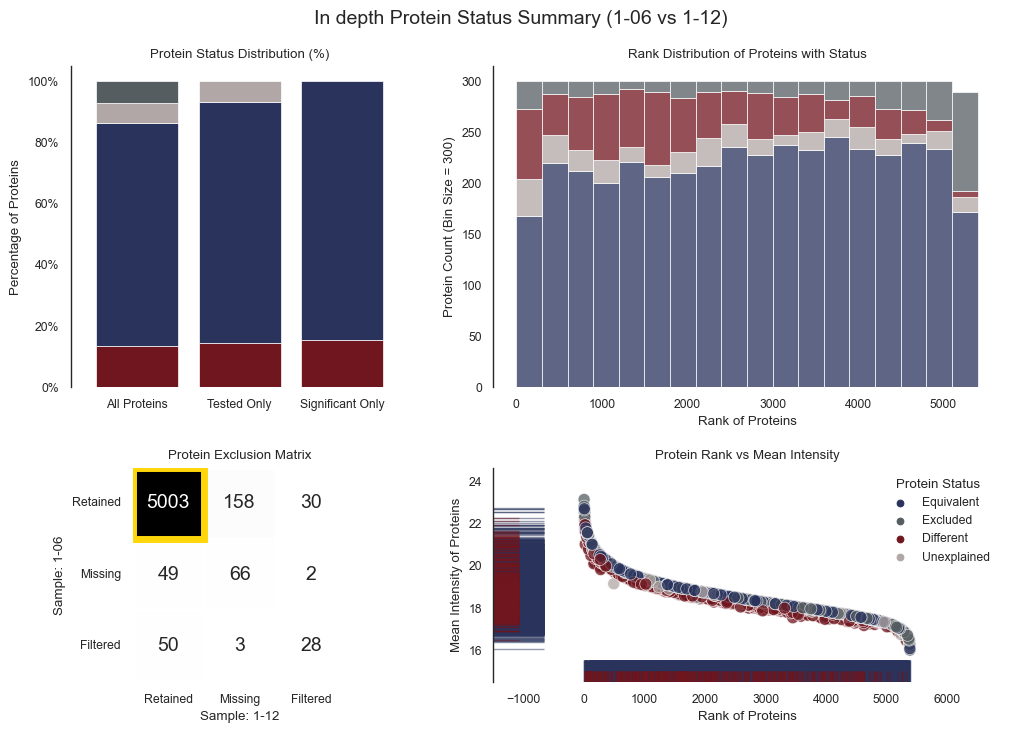

In [18]:
# Indepth summary visualization of single pairs test results
plots.single_pair_proteins_indepth(
    data = info_res,
    protein_data = protein_data,
    pair_names = cur_comb,
    # Data related parameters
    protein_col = "Protein",
    status_col = "Status",
    rank_col = "Rank",
    mean_col = "Mean",
    # Stats related parameters
    bin_size = 300,
    # Plot related parameters
    figsize = (12, 8),
    xMargin=1500,
    yMargin=1.5,
    save=save_to_folder,
    filepath=fig_path,
    filename = "single_pair_proteins_Indepth",
    fileformat=figure_formats,
    dont_show=False
)

Similar results observed however couple things to highlight is there are more protein tested in this pair since the spike-in ratios are not as different as the previous pair, which results in more E.coli proteins being quantified in both samples. Also the protein exclusion matrix shows that there are less proteins excluded to the CV filtering, which means the these samples are more reliable than 1:25 sample. 

#### Single Pair Testing Summary 

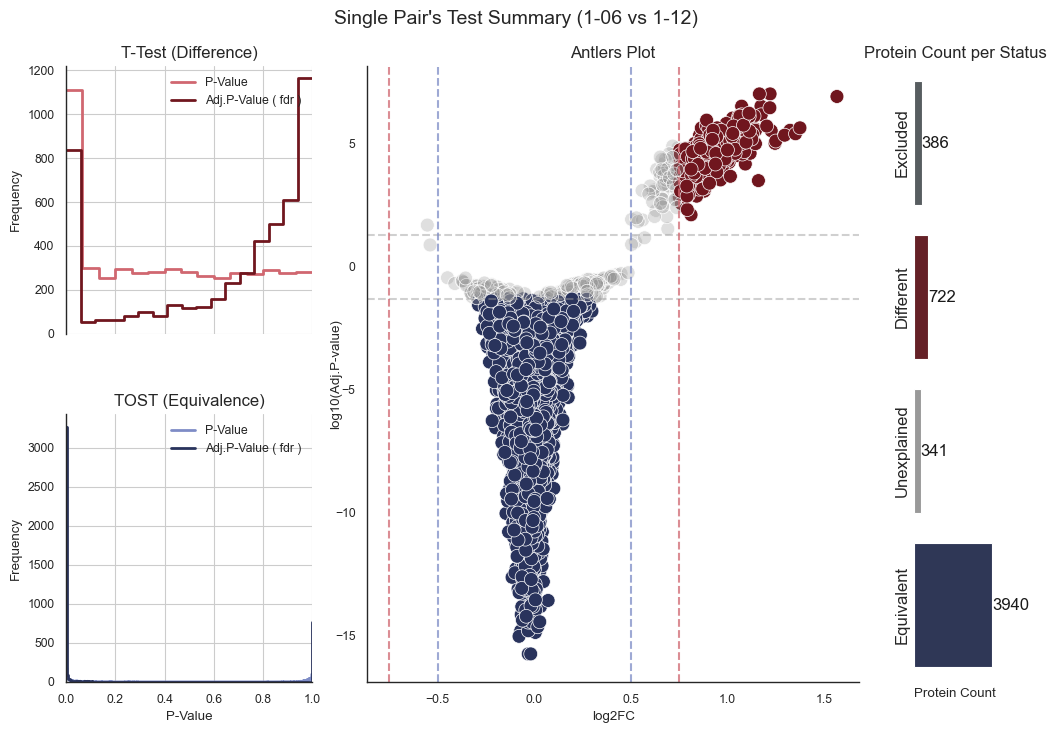

In [19]:
# Broader summary about the tested pair
plots.single_pair_summary(
    stat_res,
    info_res.shape[0],
    cur_comb,
    pThr=pThr,
    dfThr=dfThr,
    eqThr=eqThr,
    corr_name=correction_method,
    figsize=(12, 8),
    save=save_to_folder,
    filepath=fig_path,
    fileformat=figure_formats,
    dont_show=False
)

Despite the difference between the samples being 1-fold-change, there are more proteins to be statistically different (722) than 2-lfc difference pair (475). More E.coli proteins are shared within this pair, contributing to the increase in significantly identified proteins. 

Another thing to note here is that we can see the effect of the high boundary selected for the difference, which is 0.75, the same for all comparisons; however, here, since the E.coli proteins are expected to be around 1 log2 fold-change, some are picked up as unexplained. We can see this effect more when plotting the protein status overlayed on intensity comparison.

#### Protein Status Overlayed on Intensity Comparison

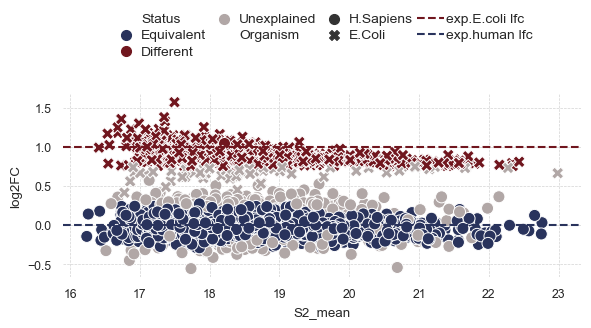

In [20]:
plot_data = stat_res[["Status", "log2FC"]].copy()

plot_data["Organism"] = plot_data.index.map(protein_info_data.set_index("entry")["organism"].to_dict())
cur_prots = plot_data.index
S1_mean = feather.read_dataframe(quant_path + f"{s1}.feather").loc[cur_prots, :].mean(axis=1)
S2_mean = feather.read_dataframe(quant_path + f"{s2}.feather").loc[cur_prots, :].mean(axis=1)
plot_data["S1_mean"] = np.log2(S1_mean)
plot_data["S2_mean"] = np.log2(S2_mean)
plot_data["mean"] = plot_data[["S1_mean", "S2_mean"]].mean(axis=1)

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
# Scatter plot with hue as the Status and shape as the organism
sns.scatterplot(
    data=plot_data,
    x="S2_mean",
    y="log2FC",
    hue="Status",
    style="Organism",
    palette=status_colors,
    ax=ax,
    s=75,
)


# Add the theoretical log2 fold change lines 
# for E. coli and human for selected Sample Pair
ax.axhline(
    y=elfc_ecoli, 
    color="#70161e", 
    linestyle="--", 
    linewidth=1.5,
    label="exp.E.coli lfc"
)
ax.axhline(
    y=elfc_human, 
    color="#29335c", 
    linestyle="--", 
    linewidth=1.5, 
    label="exp.human lfc"
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

ax.legend(
    frameon=False,
    ncol=4, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,

)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_Overlayed_Scatter_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Now I can see the E.coli proteins also have a sizeable number of unexplained proteins due to the difference boundary being close to the expected fold-change. This was one of the reasons I wanted to show these comparisons as well. The boundary selection is very important to reflect both the expected difference and the precision of the data.

The difference is less drastic, and E.coli and human proteins are beginning to blend. If there were smaller spike-in ratio differences, the precision of data would make that biological difference almost impossible to detect.

#### Protein Status per Organism 

Organism     H.Sapiens  E.Coli
Status                        
Equivalent        3940       0
Different            1     721
Unexplained        274      67
Excluded           386       0


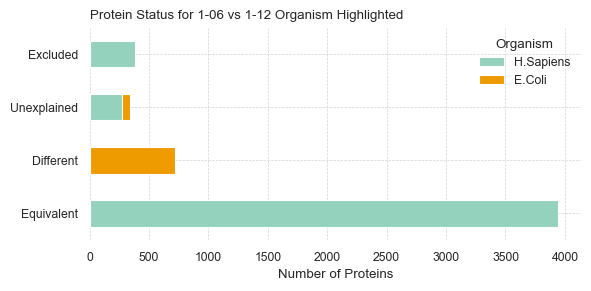

In [21]:
plot_data = info_res[["Protein", "Status"]].copy()

plot_data["Organism"] = plot_data["Protein"].map(
    protein_info_data.set_index("entry")["organism"].to_dict()
)
# plot_data.value_counts(["Organism", "Status"])
plot_data = plot_data.groupby([
    "Organism", "Status"
]).size().unstack().fillna(0).astype(int).T.loc[
    ["Equivalent", "Different", "Unexplained", "Excluded"],
    ["H.Sapiens", "E.Coli"]
]

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 3))

plot_data.plot.barh(
    ax=ax,
    stacked=True,
    color=organism_colors,
)

ax.set_xlabel("Number of Proteins")
ax.set_ylabel("")
ax.set_title(
    f"Protein Status for {s1} vs {s2} Organism Highlighted",
    # fontsize=10,
    # fontweight="bold",
    loc="left"
)
ax.legend(
    title="Organism",
    loc="upper right",
    frameon=False
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_StackedBar_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print(plot_data)

As mentioned in this comparison, the E.coli proteins are also picked up as unexplained, while different and equivalent proteins are still mainly from E.coli and humans, respectively. Finally, the excluded proteins are exclusively from humans since, in the previous notebook, we ensured to keep protein at least fully quantified in two samples. This indicates exclusion because CV filtering is not used in E.coli proteins and only affects the human proteins.


---

Again, the alternative plot is created in the manuscript for use.

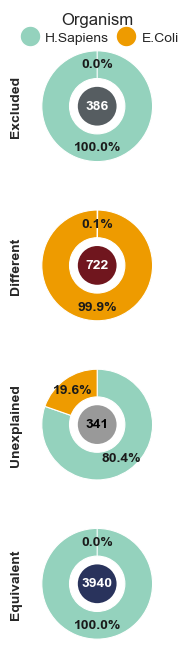

In [22]:
# Create 4 Pie charts for the 4 protein status
# Convert to percentages row-wise
plot_data = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

status_order = ["Excluded", "Different", "Unexplained", "Equivalent"]
custom_status_colors = {
        "Different": "#70161e",
        "Equivalent": "#29335c",
        "Unexplained": "#999999",
        "Excluded": "#565d61"
}  

# Initialize the figure
fig, ax = plt.subplots(
    nrows=4, 
    ncols=1, 
    figsize=(2, 8),
    gridspec_kw=dict(
        hspace=0.15
    )
)

for status in status_order:
    plot_data.loc[status].plot.pie(
        ax=ax[status_order.index(status)],
        colors=organism_colors.values(),
        autopct='%1.1f%%',
        pctdistance=0.75,
        wedgeprops=dict(width=0.5),
        startangle=90,
        counterclock=False,
        textprops=dict(
            color="k",
            fontsize=10,
            fontweight="bold"
        ),
        labels=None,
        legend=False
    )

    ax[status_order.index(status)].set_title("")
    ax[status_order.index(status)].set_ylabel(
        status, 
        fontsize=10, 
        fontweight="bold"
    )
    ax[status_order.index(status)].set_xlabel("")
    ax[status_order.index(status)].set_aspect("equal")

    # Fill middle with custom color based on status
    centre_circle = plt.Circle(
        (0, 0), 
        0.35, 
        fc=custom_status_colors[status],
        linewidth=0
    )
    ax[status_order.index(status)].add_artist(centre_circle)

    # Place the counts in the middle
    ax[status_order.index(status)].text(
        0, 
        0, 
        info_res["Status"].value_counts()[status].astype(int), 
        ha='center', 
        va='center', 
        fontsize=10,
        fontweight="bold", 
        color = plots.pick_color_based_on_background(
            custom_status_colors[status],
            hex=True
        )

    )

# Create legend from scratch
legend_elements = [
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='H.Sapiens', 
        markerfacecolor=organism_colors["H.Sapiens"], 
        markersize=10
    ),
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='E.Coli', 
        markerfacecolor=organism_colors["E.Coli"], 
        markersize=10
    ),
]

# Create the legend
ax[0].legend(
    handles=legend_elements,
    frameon=False,
    ncol=2, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,
    title="Organism",
    title_fontsize=12,
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_PieCharts_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

## No Fold-Change Pair: 1:06 vs Lymphnode

This pair includes a spiked-in sample 1:06 against the sample with no e.coli spike-in. This pair is selected to display the no-fold-change expected hence only equivalent results should arise.

In [23]:
elfc_ecoli = 0.0 # Expected log2FC for E.coli
elfc_human = 0.0 # Expected log2FC for Human
s1 = "1-06"
s2 = "Lymphnode"
cur_comb = (s1, s2)
cur_file = "_vs_".join(cur_comb)

# Get the info and stat data of the results for plotting
info_res = feather.read_dataframe(info_path+cur_file+".feather")
info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
    -1.0: "Different",
    1.0 : "Equivalent",
    0.0 : "Unexplained",
    -2  : "Excluded"
})

stat_res = feather.read_dataframe(stat_path+cur_file+".feather")
# Rename the columns
stat_res["Status"] = stat_res["Status"].replace({
    -1.0: "Different",
    1.0: "Equivalent",
    0.: "Unexplained"
})

# Save the testing results to a csv file for Supplementary Data 1
protein_info_data.set_index("entry").join(
    info_res.set_index("Protein")
).join(
    stat_res.iloc[:, :-3]
).to_csv(
    f"{supp_path}table_s1_5.csv"
)

### In-depth Summary of the Pair's Test Results

There are two figure panels that can be used to check the single pair's test results in detail.

#### In-depth Protein Status Summary

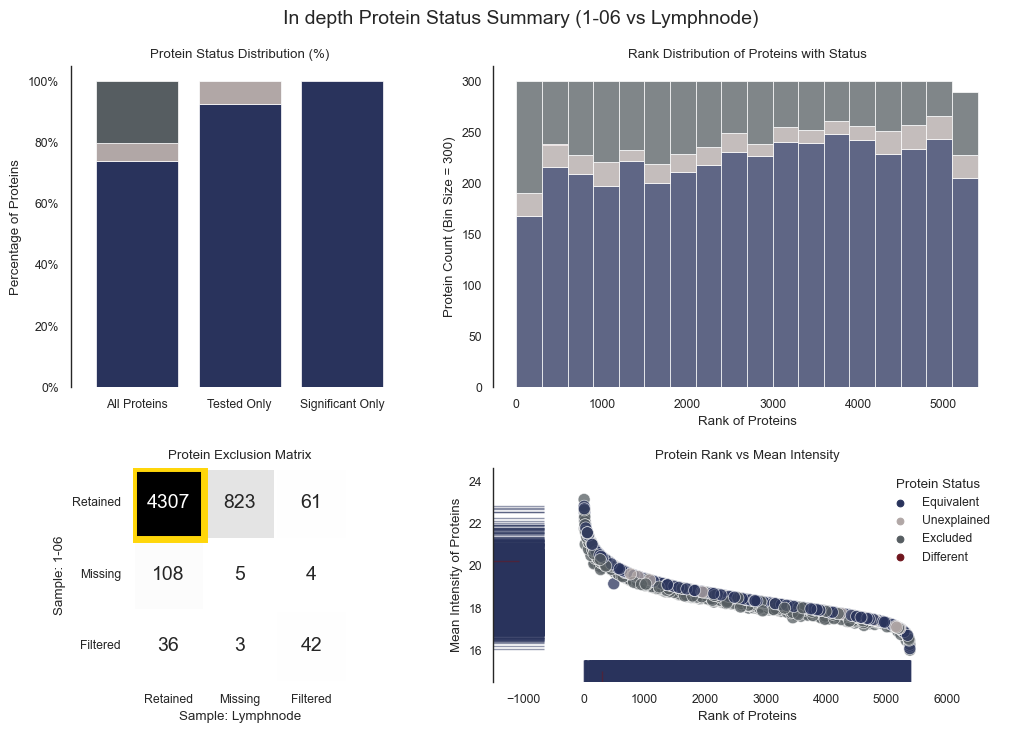

In [24]:
# Indepth summary visualization of single pairs test results
plots.single_pair_proteins_indepth(
    data = info_res,
    protein_data = protein_data,
    pair_names = cur_comb,
    # Data related parameters
    protein_col = "Protein",
    status_col = "Status",
    rank_col = "Rank",
    mean_col = "Mean",
    # Stats related parameters
    bin_size = 300,
    # Plot related parameters
    figsize = (12, 8),
    xMargin=1500,
    yMargin=1.5,
    save=save_to_folder,
    filepath=fig_path,
    filename = "single_pair_proteins_Indepth",
    fileformat=figure_formats,
    dont_show=False
)

Only equivalent proteins are observed alongside unexplained. Very high number of proteins excluded due to missing values mainly coming from existing E.coli proteins in 1:06 sample.

#### Single Pair Testing Summary 

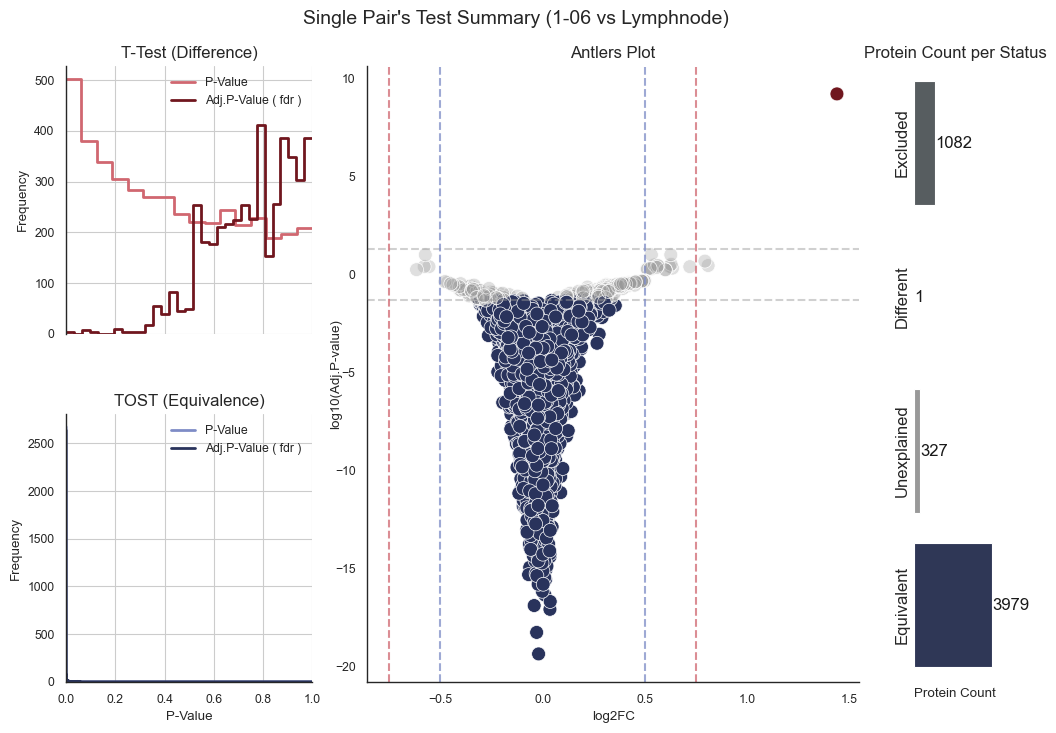

In [25]:
# Broader summary about the tested pair
plots.single_pair_summary(
    stat_res,
    info_res.shape[0],
    cur_comb,
    pThr=pThr,
    dfThr=dfThr,
    eqThr=eqThr,
    corr_name=correction_method,
    figsize=(12, 8),
    save=save_to_folder,
    filepath=fig_path,
    fileformat=figure_formats,
    dont_show=False
)

In [26]:
stat_res[stat_res["Status"]== "Different"]

,N1,N2,log2FC,df_p,df_adjp,eq_lp,eq_ladjp,eq_up,eq_uadjp,eq_p,eq_adjp,comb_p,comb_adjp,log10(pval),log10(adj_pval),Status,S1,S2
P0A6Y8,23.0000,23.0000,1.4381,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,12.8641,9.2300,Different,1-06,Lymphnode


As expected more equivalent proteins are picked up however there is one protein Chaperone protein DnaK (P0A6Y8) that is picked up as different. This is an E.coli protein that should in theory not be found in the Lymphnode sample, but it is picked up and identified as different. This is likely due to the human peptides in lymphnode matched to it to create this E.coli protein when quantified. 

#### Protein Status Overlayed on Intensity Comparison

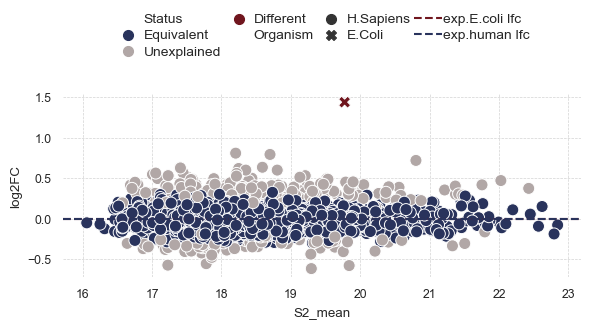

In [27]:
plot_data = stat_res[["Status", "log2FC"]].copy()

plot_data["Organism"] = plot_data.index.map(protein_info_data.set_index("entry")["organism"].to_dict())
cur_prots = plot_data.index
S1_mean = feather.read_dataframe(quant_path + f"{s1}.feather").loc[cur_prots, :].mean(axis=1)
S2_mean = feather.read_dataframe(quant_path + f"{s2}.feather").loc[cur_prots, :].mean(axis=1)
plot_data["S1_mean"] = np.log2(S1_mean)
plot_data["S2_mean"] = np.log2(S2_mean)
plot_data["mean"] = plot_data[["S1_mean", "S2_mean"]].mean(axis=1)

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 4))
# Scatter plot with hue as the Status and shape as the organism
sns.scatterplot(
    data=plot_data,
    x="S2_mean",
    y="log2FC",
    hue="Status",
    style="Organism",
    palette=status_colors,
    ax=ax,
    s=75,
)


# Add the theoretical log2 fold change lines 
# for E. coli and human for selected Sample Pair
ax.axhline(
    y=elfc_ecoli, 
    color="#70161e", 
    linestyle="--", 
    linewidth=1.5,
    label="exp.E.coli lfc"
)
ax.axhline(
    y=elfc_human, 
    color="#29335c", 
    linestyle="--", 
    linewidth=1.5, 
    label="exp.human lfc"
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

ax.legend(
    frameon=False,
    ncol=4, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,

)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_Overlayed_Scatter_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

#### Protein Status per Organism 

Organism     H.Sapiens  E.Coli
Status                        
Equivalent        3978       1
Different            0       1
Unexplained        327       0
Excluded           296     786


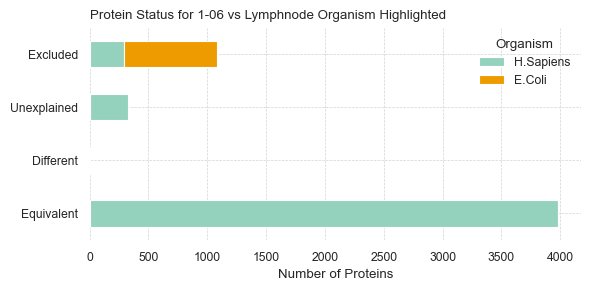

In [28]:
plot_data = info_res[["Protein", "Status"]].copy()

plot_data["Organism"] = plot_data["Protein"].map(
    protein_info_data.set_index("entry")["organism"].to_dict()
)
# plot_data.value_counts(["Organism", "Status"])
plot_data = plot_data.groupby([
    "Organism", "Status"
]).size().unstack().fillna(0).astype(int).T.loc[
    ["Equivalent", "Different", "Unexplained", "Excluded"],
    ["H.Sapiens", "E.Coli"]
]

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 3))

plot_data.plot.barh(
    ax=ax,
    stacked=True,
    color=organism_colors,
)

ax.set_xlabel("Number of Proteins")
ax.set_ylabel("")
ax.set_title(
    f"Protein Status for {s1} vs {s2} Organism Highlighted",
    # fontsize=10,
    # fontweight="bold",
    loc="left"
)
ax.legend(
    title="Organism",
    loc="upper right",
    frameon=False
)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    color="lightgrey",
)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_StackedBar_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print(plot_data)

IT seems there is another protein from E.coli that is picked up in both but this time it is identified as equivalent.

---

Again the alternative plot is created to be used if needed in the manuscript.

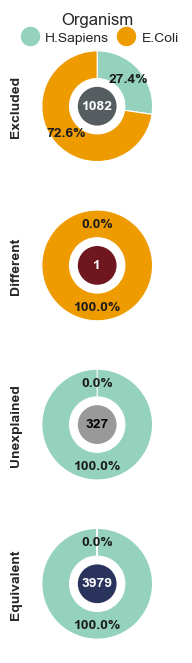

In [29]:
# Create 4 Pie charts for the 4 protein status
# Convert to percentages row-wise
plot_data = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

status_order = ["Excluded", "Different", "Unexplained", "Equivalent"]
custom_status_colors = {
        "Different": "#70161e",
        "Equivalent": "#29335c",
        "Unexplained": "#999999",
        "Excluded": "#565d61"
}  

# Initialize the figure
fig, ax = plt.subplots(
    nrows=4, 
    ncols=1, 
    figsize=(2, 8),
    gridspec_kw=dict(
        hspace=0.15
    )
)

for status in status_order:
    plot_data.loc[status].plot.pie(
        ax=ax[status_order.index(status)],
        colors=organism_colors.values(),
        autopct='%1.1f%%',
        pctdistance=0.75,
        wedgeprops=dict(width=0.5),
        startangle=90,
        counterclock=False,
        textprops=dict(
            color="k",
            fontsize=10,
            fontweight="bold"
        ),
        labels=None,
        legend=False
    )

    ax[status_order.index(status)].set_title("")
    ax[status_order.index(status)].set_ylabel(
        status, 
        fontsize=10, 
        fontweight="bold"
    )
    ax[status_order.index(status)].set_xlabel("")
    ax[status_order.index(status)].set_aspect("equal")

    # Fill middle with custom color based on status
    centre_circle = plt.Circle(
        (0, 0), 
        0.35, 
        fc=custom_status_colors[status],
        linewidth=0
    )
    ax[status_order.index(status)].add_artist(centre_circle)

    # Place the counts in the middle
    ax[status_order.index(status)].text(
        0, 
        0, 
        info_res["Status"].value_counts()[status].astype(int), 
        ha='center', 
        va='center', 
        fontsize=10,
        fontweight="bold", 
        color = plots.pick_color_based_on_background(
            custom_status_colors[status],
            hex=True
        )

    )

# Create legend from scratch
legend_elements = [
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='H.Sapiens', 
        markerfacecolor=organism_colors["H.Sapiens"], 
        markersize=10
    ),
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label='E.Coli', 
        markerfacecolor=organism_colors["E.Coli"], 
        markersize=10
    ),
]

# Create the legend
ax[0].legend(
    handles=legend_elements,
    frameon=False,
    ncol=2, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    fontsize=10,
    markerscale=1.5,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,
    title="Organism",
    title_fontsize=12,
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_ProteinStatus_OrganismGrouped_PieCharts_{s1}_vs_{s2}",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

# Correlation vs Sample equivalence index

In this section I will be comparing the correlation coefficient and the sample equivalence index (SEI) metric that can be extracted from QuEStVar to see which one captures the similarity between the samples better. My rationale in this is that the correlation coefficient is a very common way to measure the similarity between the samples, however it is best used when detecting or measuring the linear relationship between the samples. The SEI on the other hand is a measure with more precision and can be used to measure the similarity between the samples as an additional metric produced alongside the testing framework. 


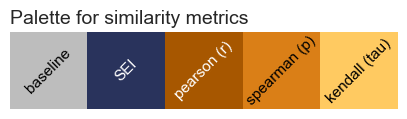

In [30]:
corr_palette = {
    "baseline": "#BDBDBD",
    "SEI": "#29335c",
    "pearson (r)": "#a75700",
    "spearman (p)": "#da7f17",
    "kendall (tau)": "#ffca61"
}
plots.color_palette(
    corr_palette,
    name="similarity metrics",
)

## Calculate Metrics

Three comparisons are included her to see the correlation coefficient and sample equivalence index (SEI) relationship. The first one is the exact same samples of Lymphnode, with no E.coli, which should have the highest correlation coefficient and SEI. The second one is the 1:06 vs 1:25 pair, which should have the lowest correlation coefficient and SEI. The third one is the 1:06 vs 1:12 pair, which should have the middle correlation coefficient and SEI.

In here the SEI is calculated by dividing the number of equivalent proteins by the total number of significant proteins.

To calculate the correlation coefficients (pearson, spearman, kendall) I create combinations of replicates from each sample to represent the pair and each pair's correlation coefficient is calculated. This gives me a distribution of correlation coefficients for each sample ranging from very different pairings to very similar pairings. 

Lastly the observeable truth is calculated by calculating how much difference is introduce to the samples by the spike-ins. It is calculated by finding the ratio of observeable E.coli proteins to the total number of proteins in the given sample pair.

In [31]:
value_dict = {}
grnd_truth = {}
for cur_comb in [
        ("1-06", "1-25"),
        ("1-06", "1-12"),
        ("Lymphnode", "Lymphnode"),
    ]:
    cur_dict = {}
    print(cur_comb)
    cur_file = "_vs_".join(cur_comb)
    info_res = feather.read_dataframe(info_path+cur_file+".feather")
    info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
        -1.0: "Different",
        1.0 : "Equivalent",
        0.0 : "Unexplained",
        -2  : "Excluded"
    })
    info_res = info_res[info_res["Status"].isin(["Different", "Equivalent"])].set_index("Protein")
    # Merge organism from protein_info_data with info_res
    info_res = info_res.merge(
        protein_info_data[["entry", "organism"]].set_index("entry"),
        left_index=True,
        right_index=True
    )
    s1_data = feather.read_dataframe(quant_path + f"{cur_comb[0]}.feather").loc[info_res.index, :]
    s2_data = feather.read_dataframe(quant_path + f"{cur_comb[1]}.feather").loc[info_res.index, :]
    # cur_average = sample_average.loc[info_res.index, list(cur_comb)].copy()
    # Percentage of H.Sapiens will be the Equivalent percentage ground truth
    cur_dict = {}
    n = 1
    
    col_pairs = list(product(s1_data.columns, s2_data.columns))
    for col_s1, col_s2 in col_pairs:
        cur_dict[f'pearson (r)-{n}'] = s1_data[col_s1].corr(s2_data[col_s2], method="pearson")
        cur_dict[f'spearman (p)-{n}'] = s1_data[col_s1].corr(s2_data[col_s2], method="spearman")
        cur_dict[f'kendall (tau)-{n}'] = s1_data[col_s1].corr(s2_data[col_s2], method="kendall")
        n += 1
    grnd_truth[cur_comb] = (info_res["organism"].value_counts(normalize=True))["H.Sapiens"]
    cur_dict["SEI"] = (info_res["Status"].value_counts(normalize=True))["Equivalent"]

    value_dict[cur_comb] = cur_dict    
    
plot_data = pd.DataFrame(value_dict).T.round(5).reset_index().rename(
    columns={"level_0": "S1", "level_1": "S2"}
).melt(
    id_vars=["S1", "S2"],
    var_name="ID",
    value_name="Value"
).sort_values(
    by=["S1", "S2"]
)

plot_data["Metric"] = plot_data["ID"].str.split("-").str[0]
plot_data["Comparison"] = plot_data["S1"] + " vs " + plot_data["S2"]

print(plot_data.shape)
plot_data.head()

('1-06', '1-25')
('1-06', '1-12')
('Lymphnode', 'Lymphnode')
(4764, 6)


,S1,S2,ID,Value,Metric,Comparison
1,1-06,1-12,pearson (r)-1,0.6942,pearson (r),1-06 vs 1-12
4,1-06,1-12,spearman (p)-1,0.7349,spearman (p),1-06 vs 1-12
7,1-06,1-12,kendall (tau)-1,0.5815,kendall (tau),1-06 vs 1-12
10,1-06,1-12,pearson (r)-2,0.6532,pearson (r),1-06 vs 1-12
13,1-06,1-12,spearman (p)-2,0.6598,spearman (p),1-06 vs 1-12


In [32]:
# Save the correlation plot's data to a csv file for Supplementary Data 1
plot_data.to_csv(
    f"{supp_path}table_s1_6.csv", 
    index=False 
)

## Visualize the Results

To visualize the results I plot the metric values on the x-axis and the sample-pairs on the y-axis. The observeable truths per sample pair is represented by yellow dashed lins. Since correlation coefficient is calculated for all possible pairs of replicates from 1 from each sample, the correlation coefficient will have many values plotted as a stripplot and the mean of the correlation coefficient will be presented as a large mean dot point, similar to equivalent percent.

Observeable Ground Truth
 1-06 vs 1-25 -> 0.8919
 1-06 vs 1-12 -> 0.8453
 Lymphnode vs Lymphnode -> 0.9995



Comparison              Metric       
1-06 vs 1-12            SEI             0.8451
                        kendall (tau)   0.6527
                        pearson (r)     0.8510
                        spearman (p)    0.8208
1-06 vs 1-25            SEI             0.8919
                        kendall (tau)   0.5521
                        pearson (r)     0.6691
                        spearman (p)    0.6782
Lymphnode vs Lymphnode  SEI             1.0000
                        kendall (tau)   0.7122
                        pearson (r)     0.8805
                        spearman (p)    0.8711
Name: Value, dtype: float64

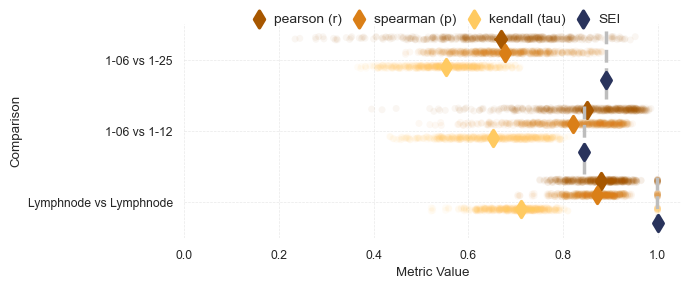

In [33]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(7, 3))
cur_order = [
    "1-06 vs 1-25",
    "1-06 vs 1-12",
    "Lymphnode vs Lymphnode"
]

sns.stripplot(
    data=plot_data, 
    x="Value",
    y="Comparison", 
    hue="Metric",
    dodge=True, 
    alpha=.05, 
    zorder=1, 
    # legend=False,
    palette=corr_palette,
    rasterized=True,
    order=cur_order,
)


# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    ax=ax,
    data=plot_data, 
    x="Value",
    y="Comparison", 
    hue="Metric",
    dodge=.85 - .8 / 3, 
    palette=corr_palette,
    join=False,
    markers="d",
    scale=1.5,
    edgecolors="k",
    markeredgecolor="k",
    order=cur_order,
)

# Place the lines for the observeable ground truth
# first line
ax.axvline(
    x=grnd_truth[("1-06", "1-25")], 
    color=corr_palette["baseline"], 
    linestyle="--", 
    linewidth=2.5,
    # label="1-06 vs 1-25",
    ymax=.975,
    ymin=.650,
)
# second line
ax.axvline(
    x=grnd_truth[("1-06", "1-12")], 
    color=corr_palette["baseline"], 
    linestyle="--", 
    linewidth=2.5,
    # label="1-06 vs 1-12",
    ymax=.625,
    ymin=.300,
)
# third line
ax.axvline(
    x=grnd_truth[("Lymphnode", "Lymphnode")], 
    color=corr_palette["baseline"], 
    linestyle="--", 
    linewidth=2.5,
    # label="Lymphnode vs Lymphnode",
    ymax=.300,
    ymin=.050,
)

handles, labels = ax.get_legend_handles_labels()

# Create the legend
ax.legend(
    # Get only last 4
    handles[-4:],
    labels[-4:],
    frameon=False,
    ncol=4, 
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    fontsize=10,
    markerscale=1.05,
    handletextpad=0.1,
    columnspacing=0.25,
    borderpad=0.25,
    labelspacing=0.25,
)

# x limit
ax.set_xlim(0, 1.05)

# Grid lines
ax.grid(
    axis="both",
    linestyle="--",
    linewidth=0.5,
    alpha=0.5,
    color="lightgrey",
)

ax.set_xlabel("Metric Value")
ax.set_ylabel("Comparison")

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = f"TestedPairs_MetricComparison_StripPlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

grnd_truth_ser = pd.Series(grnd_truth)
grnd_truth_ser.index = grnd_truth_ser.index.map(
    lambda x: " vs ".join(x)
)
grnd_truth_ser = grnd_truth_ser.loc[cur_order]

utils.print_series(
    grnd_truth_ser.round(4),
    header="Observeable Ground Truth",
)
print("")
plot_data.groupby(["Comparison", "Metric"])["Value"].mean()

Observable ground truth and percent equivalence are almost identical with extremely slight deviations. While the 1-06 vs 1-12 pair is very close to the ground truth in the pearson and spearman correlations in the rest they are quite far. While Lymphnode vs Lymphnode are same samples when you correlate the replicates they won't be exactly 1 or close to one due to technical variation, however the SEI is able to capture the similarity despite the technical variation. 

In this particular comparison we used only statistically significant proteins to calculate the metrics, to be able to directly compare the observeable truth.

# Conclusion

In this notebook I've applied the `questvar` testing framework to the spiked-in data and summarized the results. I've also compared the correlation coefficient and sample equivalence index (SEI) to see which one is a better measure of similarity between the samples.

At best the correlation coefficient can be used to measure the similarity between the samples, however it is not a robust measure and can be misleading. The SEI on the other hand is a robust measure and can be used to measure the similarity between the samples as an additional metric produced alongside the testing framework.

In [34]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:00m:29s
